<a href="https://colab.research.google.com/github/smb-h/phdr/blob/main/notebooks/nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# *-* coding: utf-8 *-*

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y
  

In [6]:
# type(train_images):  <class 'list'>
# len(train_images):  60000
#
# type(train_images[ i ]): <class 'numpy.ndarray'>
# train_images[ i ].dtype: uint8
# train_images[ i ].min(): 0
# train_images[ i ].max(): 255
# train_images[ i ].shape: (HEIGHT, WIDTH)
#
# type(train_labels):  <class 'list'>
# len(train_labels):  60000
#
# type(train_labels[ i ]): <class 'int'>
# train_labels[ i ]: 0...9
print('Reading Train 60000.cdb ...')
train_images, train_labels = read_hoda_cdb('/content/Train 60000.cdb')

# type(test_images):  <class 'list'>
# len(test_images):  20000
#
# type(test_images[ i ]): <class 'numpy.ndarray'>
# test_images[ i ].dtype: uint8
# test_images[ i ].min(): 0
# test_images[ i ].max(): 255
# test_images[ i ].shape: (HEIGHT, WIDTH)
#
# type(test_labels):  <class 'list'>
# len(test_labels):  20000
#
# type(test_labels[ i ]): <class 'int'>
# test_labels[ i ]: 0...9
print('Reading Test 20000.cdb ...')
test_images, test_labels = read_hoda_cdb('/content/Test 20000.cdb')

# type(remaining_images):  <class 'list'>
# len(remaining_images):  22352
#
# type(remaining_images[ i ]): <class 'numpy.ndarray'>
# remaining_images[ i ].dtype: uint8
# remaining_images[ i ].min(): 0
# remaining_images[ i ].max(): 255
# remaining_images[ i ].shape: (HEIGHT, WIDTH)
#
# type(remaining_labels):  <class 'list'>
# len(remaining_labels):  22352
#
# type(remaining_labels[ i ]): <class 'int'>
# remaining_labels[ i ]: 0...9
print('Reading RemainingSamples.cdb ...')
remaining_images, remaining_labels = read_hoda_cdb('/content/RemainingSamples.cdb')


Reading Train 60000.cdb ...
Reading Test 20000.cdb ...
Reading RemainingSamples.cdb ...


In [12]:
print(test_labels[:5])
print(test_images[:1])


[0, 0, 0, 0, 0]
[array([[  0,   0,   0,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
          0,   0,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255,   0,   0],
       [  0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255,   0],
       [  0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [  0, 255, 255, 255, 255, 255,   0,   0,   0,   0, 255, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255,   0],
       [  0, 

In [13]:
print(len(train_images))
print(len(test_images))


60000
20000


In [18]:
x_train = np.squeeze(train_images)
y_train = np.squeeze(train_labels)
x_test = np.squeeze(test_images)
y_test = np.squeeze(test_labels)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(60000,)
(60000,)
(20000,)
(20000,)


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [19]:
import matplotlib.pyplot as plt


label:  0


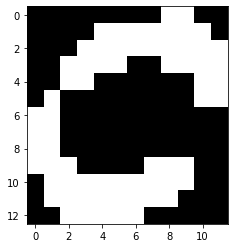

In [25]:
print("label: ", y_test[10])
plt.imshow(x_test[10], cmap="gray")
plt.show()


In [26]:
from skimage.transform import resize

# resize 5 by 5 (to reduce features)
x_train_5x5 = [resize(img, (5, 5)) for img in x_train]
x_test_5x5 = [resize(img, (5, 5)) for img in x_test]


label:  0


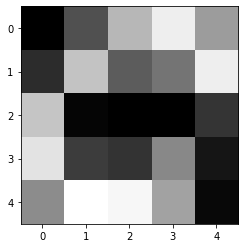

In [27]:
print("label: ", y_test[10])
plt.imshow(x_test_5x5[10], cmap="gray")
plt.show()


In [30]:
# reshape 5x5 to a vector with 25 items
x_train_5x5_feat = [x.reshape(25) for x in x_train_5x5]
x_test_5x5_feat = [x.reshape(25) for x in x_test_5x5]
